This task uses generated data that imitates Spotify logs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import os
from tqdm import *

from time import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col

from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

plt.style.use("seaborn")
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def print_cm(tp, tn, fp, fn, print_cm=True, return_cm=False):
    '''print confusion matrix'''
    cm = np.array([[tp, fp],
                   [fn, tn]])

    if print_cm:
        print(cm)
    
    if return_cm:
        return cm

In [3]:


def get_classification_score(tp, tn, fp, fn, print_stats=True, return_stats=False):

    
    accuracy = (tp+tn)/(tp+tn+fp+fn)

    try: precision = tp / (tp + fp) 
    except ZeroDivisionError: precision = np.NaN

    try: recall = tp / (tp + fn)
    except ZeroDivisionError: recall = np.NaN
    
    try: f1 = 2*precision*recall / (precision+recall)
    except ZeroDivisionError: f1 = np.NaN
        
    if print_stats:
        print("_________________")
        print("\tAccuracy:", accuracy)
        print("\tPrecision:", precision)
        print("\tRecall:",recall)
        print("\tF1 Score:", f1)
        print("_________________")
        
    if return_stats:
        return accuracy, precision, recall, f1



In [4]:
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

22/09/26 16:07:58 WARN Utils: Your hostname, k resolves to a loopback address: 127.0.1.1; using 10.4.9.55 instead (on interface enp0s3)
22/09/26 16:07:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/26 16:07:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.json("mini_sparkify_event_data.json")
df.persist();

Let us take a look at data schema 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



and a few rows

In [7]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [9]:
spark_description = df.describe().collect()

description_dict = dict()
for i in spark_description:
    
    # Turn i into dictionary
    i = i.asDict()
    
    for k, v in i.items():
        try:
            description_dict[k].append(v)
        except KeyError:
            description_dict[k] = []
            description_dict[k].append(v)

df_desc = pd.DataFrame(description_dict).T.reset_index()
df_desc.columns = df_desc.iloc[0]
df_desc = df_desc[1:]

df_desc

,summary,count,mean,stddev,min,max
1,artist,228108,551.0852017937219,1217.7693079161374,!!!,ÃÂlafur Arnalds
2,auth,286500,None,None,Cancelled,Logged Out
3,firstName,278154,None,None,Adelaida,Zyonna
4,gender,278154,None,None,F,M
5,itemInSession,286500,114.41421291448516,129.76726201140994,0,1321
6,lastName,278154,None,None,Adams,Wright
7,length,228108,249.1171819778458,99.23517921058361,0.78322,3024.66567
8,level,286500,None,None,free,paid
9,location,278154,None,None,"Albany, OR","Winston-Salem, NC"
10,method,286500,None,None,GET,PUT


### Data cleaning

In [10]:
df.createOrReplaceTempView("df")

In [11]:
null_dict = {}

for i in df.columns:
    
    nulls = spark.sql("SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS null_{} \
                    FROM df \
                    where {} is null".format(i, i, i)).collect()[0]["null_{}".format(i)]
    
    print(i, nulls)
    null_dict[i] = nulls

artist 58392
auth None
firstName 8346
gender 8346
itemInSession None
lastName 8346
length 58392
level None
location 8346
method None
page None
registration 8346
sessionId None
song 58392
status None
ts None
userAgent 8346
userId None


we can see that there are columns that are never null. We could use quartets (userId,ts, itemInSession, page) as Unique key. Indeed,

In [12]:
spark.sql("SELECT userId, ts, itemInSession, page, count(*) AS n_rows \
        FROM df \
        GROUP BY 1, 2, 3,4 \
        HAVING count(*) > 1 \
        ORDER BY 3 DESC \
        LIMIT 10").collect()

[]

and we can see thath there are no rows with the same userId, ts, itemInSession, page.

In [13]:
df_unique = spark.sql("WITH T AS (SELECT *, ROW_NUMBER() OVER (PARTITION BY userId, ts ORDER BY itemInSession) as rank\
                    FROM df ) \
                    SELECT * FROM T \
                    WHERE rank = 1")

df_unique.createOrReplaceTempView("df_unique")

### Missing Values

In [14]:
nan_dict = {}

for i in ["firstName", "gender", "lastName", "location", "userAgent"]:
    returns = spark.sql("""
        SELECT SUM(CASE WHEN {} IS NULL THEN 1 ELSE 0 END) AS nulls 
        FROM df_unique
        WHERE registration IS NOT NULL
    """.format(i)).collect()
    
    nan_dict[i] = returns[0].nulls
    
print(nan_dict)

{'firstName': 0, 'gender': 0, 'lastName': 0, 'location': 0, 'userAgent': 0}


In [15]:
spark.sql("""
    SELECT page,
           COUNT(*)                                        AS n_rows,
           SUM(CASE WHEN song IS NULL THEN 1 ELSE 0 END)   AS null_songs,
           SUM(CASE WHEN artist IS NULL THEN 1 ELSE 0 END) AS null_artist
    FROM df_unique
    GROUP BY 1
""").collect()

[Row(page='Cancel', n_rows=52, null_songs=52, null_artist=52),
 Row(page='Submit Downgrade', n_rows=63, null_songs=63, null_artist=63),
 Row(page='Thumbs Down', n_rows=2546, null_songs=2546, null_artist=2546),
 Row(page='Home', n_rows=14235, null_songs=14235, null_artist=14235),
 Row(page='Downgrade', n_rows=2001, null_songs=2001, null_artist=2001),
 Row(page='Roll Advert', n_rows=3805, null_songs=3805, null_artist=3805),
 Row(page='Logout', n_rows=3226, null_songs=3226, null_artist=3226),
 Row(page='Save Settings', n_rows=310, null_songs=310, null_artist=310),
 Row(page='Cancellation Confirmation', n_rows=51, null_songs=51, null_artist=51),
 Row(page='About', n_rows=904, null_songs=904, null_artist=904),
 Row(page='Submit Registration', n_rows=5, null_songs=5, null_artist=5),
 Row(page='Settings', n_rows=1470, null_songs=1470, null_artist=1470),
 Row(page='Login', n_rows=3240, null_songs=3240, null_artist=3240),
 Row(page='Register', n_rows=18, null_songs=18, null_artist=18),
 Row(pag

There doesn't seem to be any issues with dataset

## Exploratory Data Analysis

#### How many distinct users are there in our dataset?

In [16]:


spark.sql("""
    SELECT CASE WHEN registration IS NULL THEN 0 ELSE 1 END AS is_registered,
    COUNT(DISTINCT du.userId) 
    FROM df_unique AS du 
    GROUP BY 1
    ORDER BY 1

""").collect()



[Row(is_registered=0, count(DISTINCT userId)=1),
 Row(is_registered=1, count(DISTINCT userId)=225)]

#### Which pages are the most visited for each user?

In [17]:
response = spark.sql("""
    SELECT page, COUNT(userId) AS counts
    FROM df_unique
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

pages_non_distinct_view = [i.page for i in response]
non_distinct_view = [i.counts for i in response]

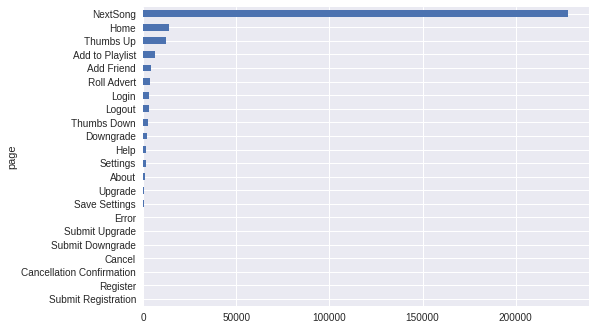

In [18]:
response = spark.sql("""
    WITH user_pages AS (
        SELECT DISTINCT userId, 
                        page 
        FROM df_unique
    )
    
    SELECT page, COUNT(DISTINCT userId) AS counts
    FROM user_pages
    GROUP BY 1
    ORDER BY 1 DESC
""").collect()

distinct_view = [i.counts for i in response]

df_page_vists = pd.DataFrame(dict(page = pages_non_distinct_view,
                                  distinct_view = distinct_view,
                                  non_distinct_view = non_distinct_view))

ax = df_page_vists.sort_values("non_distinct_view").set_index("page")["non_distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();

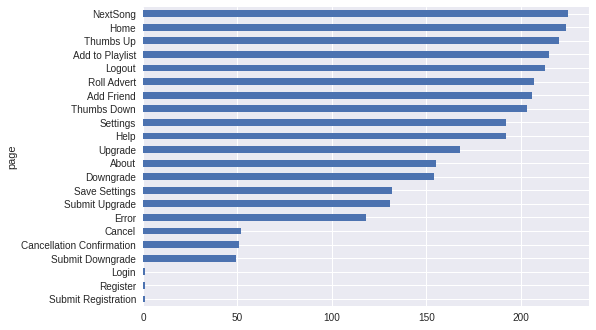

In [19]:


ax = df_page_vists.sort_values("distinct_view").set_index("page")["distinct_view"].plot(kind="barh", 
                                                                                                color=color_cycle[0])
ax.plot();



Looking at distinct users shows that things not so imbalanced. We can see that out of roughly 225 registered users, roughly 50 of them end up downgrading.


#### What location are our users mostly from?

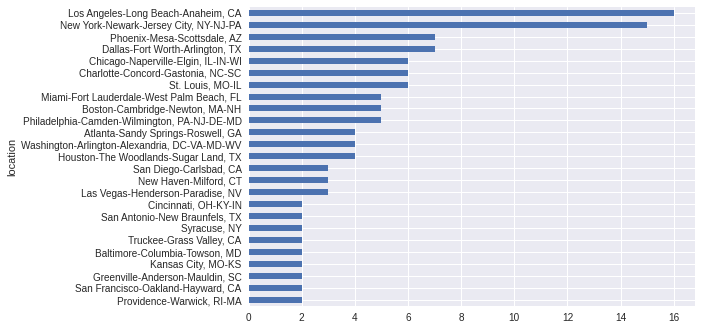

In [20]:
response = spark.sql("""
    WITH user_locations AS (
        SELECT DISTINCT userId, 
                        location 
        FROM df_unique
    )
    
    SELECT location, COUNT(DISTINCT userId) AS counts
    FROM user_locations
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 25  -- Note that without a limit, the graph will overplot
""").collect()

location = [i.location for i in response]
location_counts = [i.counts for i in response]

df_locations = pd.DataFrame(dict(location = location,
                                 location_counts = location_counts))

ax = df_locations.sort_values("location_counts").set_index("location")["location_counts"].plot(kind="barh", 
                                                                                               color=color_cycle[0])
ax.plot();

#### Gender distribution

In [21]:
gender = spark.sql("""
    WITH user_gender AS (
        SELECT DISTINCT userId, gender
        FROM df_unique
    )

    SELECT gender, COUNT(*) AS counts
    FROM user_gender
    GROUP BY 1
    ORDER BY 1
""").collect()

gender



[Row(gender=None, counts=1),
 Row(gender='F', counts=104),
 Row(gender='M', counts=121)]

The person with a null gender is an unregistered user.

In [22]:
males = [i.counts for i in gender if i.gender=='F'][0]
females = [i.counts for i in gender if i.gender=='M'][0]

males, females

(104, 121)

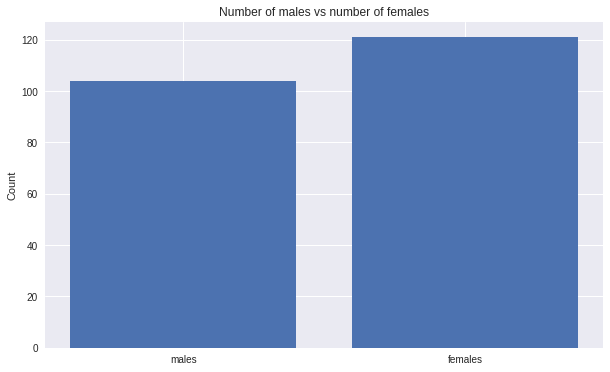

In [23]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.bar(["males", "females"], [males, females])
plt.title("Number of males vs number of females")
plt.ylabel("Count")
plt.show()



### when is a user likely to unsubscribe from services


possible reasons:

When their "use" of the platform starts to slow down.
When they can't even use the platform due to erroes.
When they decide to use another platform. (Not actionable)
When they decide that they would rather save the money they spend on the service. (Not actionable)
When friends start to ubsubscribe (network effects)
When they listen to songs that they don't like


so, we should check for:

The distribution of those who visit the cancelation confirmation page and intra-session time.
Total play time per unit of time. Or even the number of pages visited per unit oftime.
If people are more likely to ubsubscribe if their direct friends unsubscribe.
Another useful signal is the number of error pages that they get. (Or event he number of times they check the help)
In addition to this, let's look at the ratio of likes vs dislikes.


#### intrasession time correlation with cancellation

In [24]:
response = spark.sql("""
    WITH usr_cancelsub AS (
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled
    FROM df_unique
    GROUP BY 1
    ),
    
    usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    )
    
    SELECT uc.*, ui.avg_intra_session_time
    FROM usr_cancelsub AS uc
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = uc.userId
""").collect()

In [25]:
intrasesh_times = [i.avg_intra_session_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_intrasesh_cancelation = pd.DataFrame(dict(intrasesh_times = intrasesh_times,
                                            is_canceled = is_canceled))

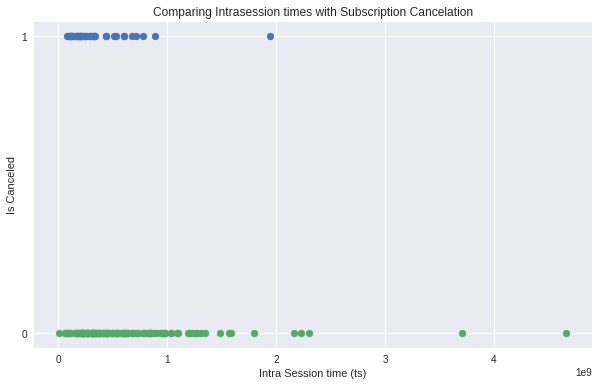

In [26]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["intrasesh_times"], 
            df_intrasesh_cancelation[df_intrasesh_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Intrasession times with Subscription Cancelation")
plt.xlabel("Intra Session time (ts)")
plt.ylabel("Is Canceled")
plt.show()

#### Total play time correlation with Cancelation

In [27]:
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(length) AS total_play_time
    FROM df_unique
    GROUP BY 1
""").collect()

In [28]:
total_play_time = [i.total_play_time for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(total_play_time = total_play_time,
                                            is_canceled = is_canceled))

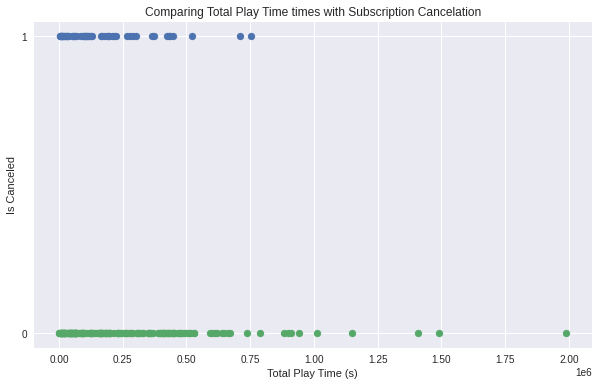

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["total_play_time"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Total Play Time times with Subscription Cancelation")
plt.xlabel("Total Play Time (s)")
plt.ylabel("Is Canceled")
plt.show()

#### Effect of network on unsubscribing

In [30]:
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END) AS n_friends_added
    FROM df_unique
    GROUP BY 1
""").collect()

In [31]:
friends_added = [i.n_friends_added for i in response]
is_canceled = [i.is_canceled for i in response]

df_playtime_cancelation = pd.DataFrame(dict(friends_added = friends_added,
                                            is_canceled = is_canceled))

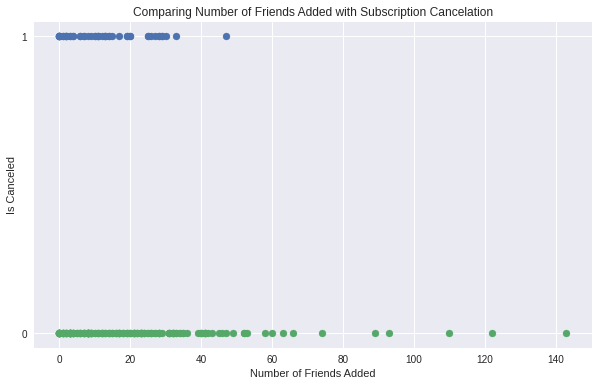

In [32]:


fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["friends_added"], 
            df_playtime_cancelation[df_playtime_cancelation["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Friends Added with Subscription Cancelation")
plt.xlabel("Number of Friends Added")
plt.ylabel("Is Canceled")
plt.show()



#### Number of Error Pages

In [33]:
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Error' THEN 1 ELSE 0 END) AS n_errors
    FROM df_unique
    GROUP BY 1
""").collect()

In [34]:
errors = [i.n_errors for i in response]
is_canceled = [i.is_canceled for i in response]

df_errors = pd.DataFrame(dict(errors = errors,
                              is_canceled = is_canceled))

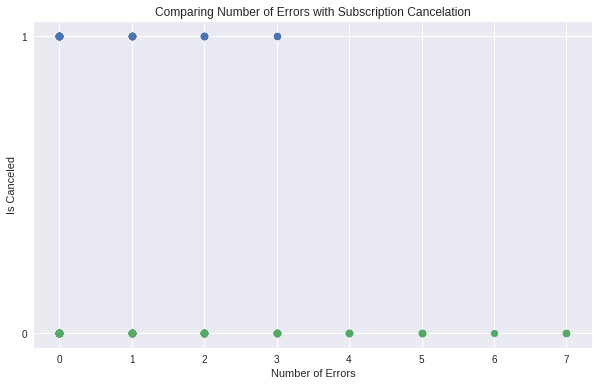

In [35]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(df_errors[df_errors["is_canceled"] == 1]["errors"], 
            df_errors[df_errors["is_canceled"] == 1]["is_canceled"])
plt.scatter(df_errors[df_errors["is_canceled"] == 0]["errors"], 
            df_errors[df_errors["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Number of Errors with Subscription Cancelation")
plt.xlabel("Number of Errors")
plt.ylabel("Is Canceled")
plt.show()

#### Like/Dislike Ratio

In [36]:
response = spark.sql("""
    SELECT userId,
           MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END) AS is_canceled,
           SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END)/
           SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END)AS likes_v_dislikes
    FROM df_unique
    GROUP BY 1
""").collect()

In [37]:


likes_v_dislikes = [i.likes_v_dislikes for i in response]
is_canceled = [i.is_canceled for i in response]

l_v_d = pd.DataFrame(dict(likes_v_dislikes = likes_v_dislikes,
                              is_canceled = is_canceled))

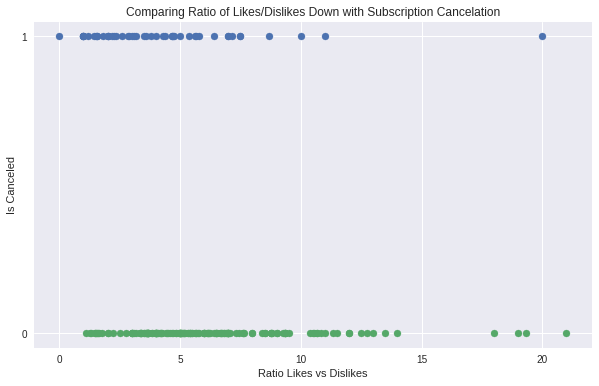

In [38]:
fig, ax = plt.subplots(figsize=(10, 6), edgecolor='k', facecolor='white')
plt.scatter(l_v_d[l_v_d["is_canceled"] == 1]["likes_v_dislikes"], 
            l_v_d[l_v_d["is_canceled"] == 1]["is_canceled"])
plt.scatter(l_v_d[l_v_d["is_canceled"] == 0]["likes_v_dislikes"], 
            l_v_d[l_v_d["is_canceled"] == 0]["is_canceled"])
plt.yticks((0, 1))
plt.title("Comparing Ratio of Likes/Dislikes Down with Subscription Cancelation")
plt.xlabel("Ratio Likes vs Dislikes")
plt.ylabel("Is Canceled")
plt.show()

### Feature Engineering

Based on the previous analysis we will use the following features: \
  1.intra-session time.\
  2.Total play time\
  3.Number of Friends.\
  4.Ratio of likes vs dislikes.

In [39]:
df_features_raw = spark.sql("""
    WITH usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    ) 

    SELECT du.userId,
           NVL(ui.avg_intra_session_time, 0) AS avg_intra_session_time,
           NVL(SUM(length), 0) AS total_play_time, 
           NVL(SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END), 0) AS n_friends_added,
           NVL(SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) /
               SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END), 0) AS Ratio_TU_v_TD,
           NVL(MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END), 0) AS label
    FROM df_unique AS du
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = du.userId
    GROUP BY 1, 2
""")


df_features_raw.createOrReplaceTempView("df_features_raw")

In [40]:
cols = df_features_raw.columns[1:-1]
assembler = VectorAssembler(inputCols=cols, 
                            outputCol="Vec")

df_features_unnormalised = assembler.transform(df_features_raw)

In [41]:
scaler = Normalizer(inputCol="Vec", outputCol="features")
df_features = scaler.transform(df_features_unnormalised).select(["features", "label"])

### Modeling

#### Logistic regression

In [42]:
train, validation = df_features.randomSplit([0.8, 0.2], seed=61241)

In [43]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

crossval.setSeed(42)
if not os.path.isdir("./logisticRegression1"):
    
    print("Model not existing yet, training a new one...")
    
    train_time_start = time()
    
    cvModel_lr = crossval.fit(train)

    train_time_end = time()
    
    print("Training complete! \n\t Training time:", (train_time_end - train_time_start)/60, "mins.")

    cvModel_lr.save("./logisticRegression1")
else:
    print("Loading existing model")
    cvModel_lr = CrossValidatorModel.load("./logisticRegression1")

Model not existing yet, training a new one...


22/09/26 16:08:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/09/26 16:08:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Training complete! 
	 Training time: 8.376009825865427 mins.


Model Evaluation

In [44]:
train_results = cvModel_lr.transform(train)


tp_train = train_results.filter("label = 1 and prediction = 1").count()
fp_train = train_results.filter("label = 0 and prediction = 1").count()
fn_train = train_results.filter("label = 1 and prediction = 0").count()
tn_train = train_results.filter("label = 0 and prediction = 0").count()


train_classifications = [tp_train, 
                        tn_train, 
                        fp_train, 
                        fn_train]

Confusion matrix

In [45]:
print_cm(*train_classifications)

[[  2   0]
 [ 43 140]]


Metrics

In [59]:
get_classification_score(*train_classifications)

_________________
	Accuracy: 0.7675675675675676
	Precision: 1.0
	Recall: 0.044444444444444446
	F1 Score: 0.0851063829787234
_________________


In [60]:
validation_results = cvModel_lr.transform(validation)

tp_valid = validation_results.filter("label = 1 and prediction = 1").count()
fp_valid = validation_results.filter("label = 0 and prediction = 1").count()
fn_valid = validation_results.filter("label = 1 and prediction = 0").count()
tn_valid = validation_results.filter("label = 0 and prediction = 0").count()

valid_classifications = [tp_valid, 
                         tn_valid, 
                         fp_valid, 
                         fn_valid]

Validation confusion matrix

In [61]:
print_cm(*valid_classifications)

[[ 0  1]
 [ 6 34]]


Validation metrics

In [62]:
get_classification_score(*valid_classifications)

_________________
	Accuracy: 0.8292682926829268
	Precision: 0.0
	Recall: 0.0
	F1 Score: nan
_________________


Next, let's take a look at the featurs coefficients

In [63]:
df_lr_coeff = pd.DataFrame(dict(feature = df_features_raw.columns[1:-1]+["Intercept"],
                                coefficient = [i for i in cvModel_lr.bestModel.coefficients]+\
                                [i for i in [cvModel_lr.bestModel.intercept]]))
df_lr_coeff.sort_values("coefficient", ascending=False)

,feature,coefficient
3,Ratio_TU_v_TD,2641.181846
2,n_friends_added,1980.361868
0,avg_intra_session_time,0.000000
1,total_play_time,0.000000
4,Intercept,-1.178259


<AxesSubplot:ylabel='feature'>

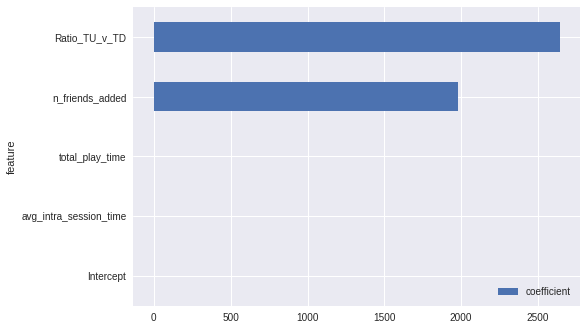

In [64]:
df_lr_coeff.sort_values("coefficient", ascending=True).set_index("feature").plot(kind="barh")

The average intra session time and total play time doesnt seem to be signifcant

It seems people will stay depending on  how much they like the music that they are listening to and their social interactions.

#### Alternative Model: Decision Tree

In [66]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

crossval.setSeed(42)

if not os.path.isdir("./decisionTree1"):
    
    print("Model not existing yet, training a new one...")
    
    train_time_start = time()

    cvModel_dt = crossval_dt.fit(train)

    train_time_end = time()
    
    print("Training complete! \n\t Training time:", (train_time_end - train_time_start)/60, "mins.")
    
    cvModel_dt.save("./decisionTree1")
else:
    print("Loading existing model")
    cvModel_dt = CrossValidatorModel.load("./decisionTree1")

Model not existing yet, training a new one...


22/09/26 16:21:11 WARN CacheManager: Asked to cache already cached data.
22/09/26 16:21:11 WARN CacheManager: Asked to cache already cached data.


Training complete! 
	 Training time: 8.807256364822388 mins.


In [67]:
df_features_raw2 = spark.sql("""
    WITH usr_intrasesh AS (
    SELECT userId, 
           itemInSession, 
           ts - LAG(ts) OVER (PARTITION BY userId ORDER BY ts) AS intra_session_time
    FROM df_unique
    WHERE itemInSession = 0
    ) 

    SELECT du.userId,
           NVL(ui.avg_intra_session_time, 0) AS avg_intra_session_time,
           NVL(SUM(length), 0) AS total_play_time, 
           NVL(SUM(CASE WHEN page = 'Add Friend' THEN 1 ELSE 0 END), 0) AS n_friends_added,
           NVL(SUM(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE 0 END) /
               SUM(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE 0 END), 0) AS Ratio_TU_v_TD,
           NVL(COUNT(DISTINCT artist), 0) AS n_artists,
           NVL(COUNT(song), 0) AS n_songs,
           NVL(SUM(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE 0 END), 0) AS n_added_to_playlist,
           NVL(MAX(CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END), 0) AS label
    FROM df_unique AS du
    LEFT JOIN (SELECT userId, AVG(intra_session_time) avg_intra_session_time
               FROM usr_intrasesh
               GROUP BY 1) AS ui
               ON ui.userId = du.userId
    GROUP BY 1, 2
""")

df_features_raw.createOrReplaceTempView("df_features_raw2")

In [70]:
cols = df_features_raw2.columns[1:-1]

assembler = VectorAssembler(inputCols=cols, 
                            outputCol="Vec")

df_features_unnormalised2 = assembler.transform(df_features_raw2)

In [71]:
df_features2 = scaler.transform(df_features_unnormalised2).select(["features", "label"])

In [72]:
train2, validation2 = df_features2.randomSplit([0.8, 0.2], seed=5318008)

In [73]:
train_results2 = cvModel_dt.transform(train2)

In [74]:
tp_train2 = train_results2.filter("label = 1 and prediction = 1").count()
fp_train2 = train_results2.filter("label = 0 and prediction = 1").count()
fn_train2 = train_results2.filter("label = 1 and prediction = 0").count()
tn_train2 = train_results2.filter("label = 0 and prediction = 0").count()

In [75]:
test_classifications2 = [tp_train2, 
                        tn_train2, 
                        fp_train2, 
                        fn_train2]

Decision tree confusion matrix

In [76]:
print_cm(*test_classifications2)

[[ 19  13]
 [ 23 124]]


Decision tree metrics

In [77]:
get_classification_score(*test_classifications2)

_________________
	Accuracy: 0.7988826815642458
	Precision: 0.59375
	Recall: 0.4523809523809524
	F1 Score: 0.5135135135135135
_________________


In [78]:
valid_results2 = cvModel_dt.transform(validation2)

tp_valid2 = valid_results2.filter("label = 1 and prediction = 1").count()
fp_valid2 = valid_results2.filter("label = 0 and prediction = 1").count()
fn_valid2 = valid_results2.filter("label = 1 and prediction = 0").count()
tn_valid2 = valid_results2.filter("label = 0 and prediction = 0").count()

valid_classifications2 = [tp_valid2, 
                         tn_valid2, 
                         fp_valid2, 
                         fn_valid2]

In [79]:


print_cm(*valid_classifications2)


[[ 7  1]
 [ 2 37]]


In [80]:
get_classification_score(*valid_classifications2)

_________________
	Accuracy: 0.9361702127659575
	Precision: 0.875
	Recall: 0.7777777777777778
	F1 Score: 0.823529411764706
_________________


In [81]:
cvModel_dt.bestModel._java_obj.getImpurity(), cvModel_dt.bestModel._java_obj.getMaxDepth()

('gini', 6)

We can see that decision tree model improves score significantly